# Практическое задание к уроку 1 (2 неделя).
## Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

Напоминаем, что посмотреть справку любого метода или функции (узнать, какие у нее аргументы и что она делает) можно с помощью комбинации Shift+Tab. Нажатие Tab после имени объекта и точки позволяет посмотреть, какие методы и переменные есть у этого объекта.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки (как они были указаны в источнике данных):
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

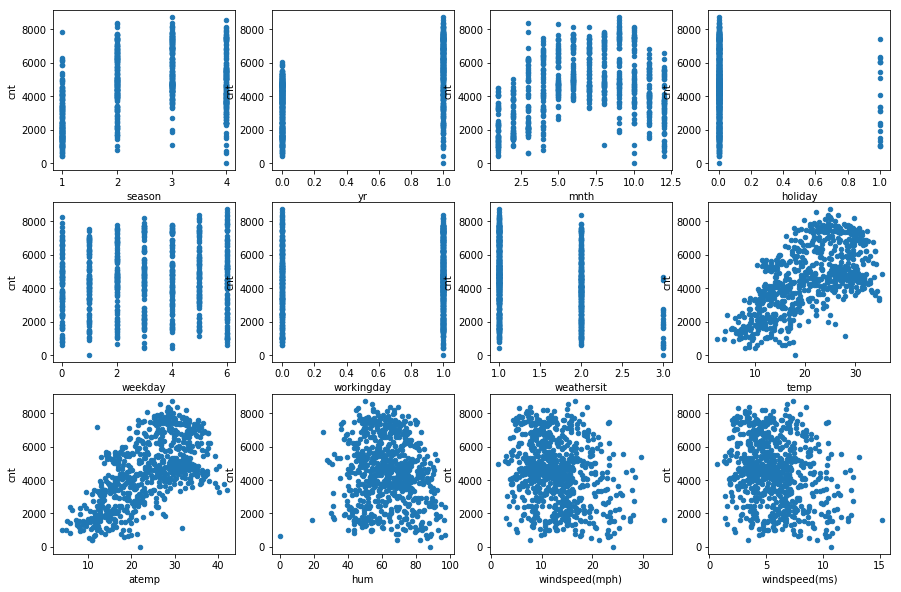

In [159]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

__Блок 1. Ответьте на вопросы (каждый 0.5 балла):__
1. Каков характер зависимости числа прокатов от месяца? 
   * ответ: cnt/mnth - синусоидальный характер зависимости с периодом, равным году 
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
   * ответ: temp, atemp - температура и температура по ощущениям

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод df.corr вычисляет матрицу корреляций всех признаков из датафрейма. Методу df.corrwith нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [163]:
# To find the correlation among the columns using pearson method 
# Посчитайте корреляции всех признаков, кроме последнего,
print df.iloc[:, :-1].corr(method ='pearson')
# с последним с помощью метода corrwith:
print '\nCorrelation of the last column with others\n\n', df.corrwith(df.cnt)

                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp           0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum             0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed(mph) -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
windspeed(ms)  -0.229046 -0.011817 -0.20

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [5]:
# Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
# с помощью метода corr:
df[['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']].corr()


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [6]:
# Выведите средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
# shuffle the dataframe
# if you use random_state=some_number, then you can guarantee that the output 
# of Run 1 will be equal to the output of Run 2, i.e. your split will be always the same.
df_shuffled = shuffle(df, random_state=123)
# scale method standardize a dataset along any axis
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

/home/thomas/anaconda2/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [10]:
from sklearn.linear_model import LinearRegression

In [32]:
# Создайте объект линейного регрессора,  
linear_regression_object = LinearRegression()
# обучите его на всех данных 
fitted_LR = linear_regression_object.fit(X, y)
# и выведите веса модели
# (веса хранятся в переменной coef_ класса регрессора).
# Можно выводить пары (название признака, вес), воспользовавшись функцией zip, 
# встроенной в язык python
# Названия признаков хранятся в переменной df.columns
the_features_weights = zip(df.columns, fitted_LR.coef_.round(2))
print 'Features weights'
the_features_weights
# too big ones!

Features weights


[('season', 570.87),
 ('yr', 1021.97),
 ('mnth', -141.3),
 ('holiday', -86.76),
 ('weekday', 137.22),
 ('workingday', 56.39),
 ('weathersit', -330.23),
 ('temp', 367.48),
 ('atemp', 585.55),
 ('hum', -145.61),
 ('windspeed(mph)', 12456993930211.94),
 ('windspeed(ms)', -12456993930410.4)]

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_, вы обсуждали ее на лекции.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge. Подробнее об этом также рассказано в лекции.

Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

In [33]:
from sklearn.linear_model import Lasso, Ridge

In [34]:
# Обучите линейную модель с L1-регуляризацией и выведите веса
# Linear Model trained with L1 prior as regularizer (aka the Lasso)
linear_model_Lasso_reg = Lasso()
fitted_LML = linear_model_Lasso_reg.fit(X, y)
the_LML_features_weights = zip(df.columns, fitted_LML.coef_.round(2))
print 'LML Features weights'
the_LML_features_weights



LML Features weights


[('season', 560.24),
 ('yr', 1019.46),
 ('mnth', -128.73),
 ('holiday', -86.15),
 ('weekday', 137.35),
 ('workingday', 55.21),
 ('weathersit', -332.37),
 ('temp', 376.36),
 ('atemp', 576.53),
 ('hum', -144.13),
 ('windspeed(mph)', -197.14),
 ('windspeed(ms)', -0.0)]

In [36]:
# Обучите линейную модель с L2-регуляризацией и выведите веса
# Linear least squares with l2 regularization
linear_model_Ridge_reg = Ridge()
fitted_LMR = linear_model_Ridge_reg.fit(X, y)
the_LMR_features_weights = zip(df.columns, fitted_LR.coef_.round(2), fitted_LML.coef_.round(2), fitted_LMR.coef_.round(2))
print 'LR, LML, LMR Features weights'
the_LMR_features_weights


LR, LML, LMR Features weights


[('season', 570.87, 560.24, 563.06),
 ('yr', 1021.97, 1019.46, 1018.95),
 ('mnth', -141.3, -128.73, -131.87),
 ('holiday', -86.76, -86.15, -86.75),
 ('weekday', 137.22, 137.35, 138.01),
 ('workingday', 56.39, 55.21, 55.9),
 ('weathersit', -330.23, -332.37, -332.35),
 ('temp', 367.48, 376.36, 386.46),
 ('atemp', 585.55, 576.53, 566.35),
 ('hum', -145.61, -144.13, -145.07),
 ('windspeed(mph)', 12456993930211.94, -197.14, -99.26),
 ('windspeed(ms)', -12456993930410.4, -0.0, -99.26)]

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. Объяснение данному факту дается в одной из лекций курса.

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$ (в лекции коэффициент при регуляризаторе мог быть обозначен другой буквой).

In [50]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучите регрессор Lasso
# и запишите веса в соответствующую строку матрицы coefs_lasso 
# (вспомните встроенную в python функцию enumerate),
# The enumerate() function takes a collection (e.g. a tuple) 
# and returns it as an enumerate object.
# The enumerate() function adds a counter as the key of the enumerate object.
for index, value in enumerate(alphas):
    Lasso_regressor_i = Lasso(alpha=value)
    Lasso_regressor_i.fit(X, y)
    coefs_lasso[index] = Lasso_regressor_i.coef_ 
# а затем обучите Ridge и запишите веса в coefs_ridge.
for index, value in enumerate(alphas):
    Ridge_regressor_i = Ridge(alpha=value)
    Ridge_regressor_i.fit(X, y)
    coefs_ridge[index] = Ridge_regressor_i.coef_ 

Lasso_regressor_001 = Lasso(alpha=1e-3)
Lasso_regressor_001.fit(X, y)
coefs_lasso_001 = Lasso_regressor_001.coef_ 
print coefs_lasso_001.round(2)
Ridge_regressor_001 = Ridge(alpha=1e-3)
Ridge_regressor_001.fit(X, y)
coefs_ridge_001 = Ridge_regressor_001.coef_ 
print coefs_ridge_001.round(2)

[ 565.87 1020.35 -134.46  -86.69  138.36   55.95 -332.7   371.27  581.78
 -145.01 -198.07   -0.  ]
[ 565.87 1020.35 -134.46  -86.69  138.36   55.96 -332.7   371.16  581.89
 -145.02  -99.04  -99.04]


Визуализируем динамику весов при увеличении параметра регуляризации:

Text(0.5,1,'Ridge')

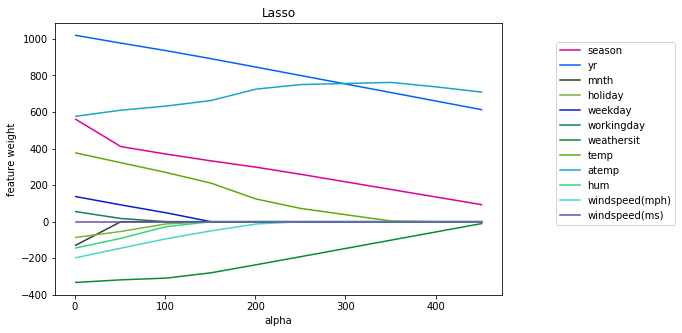

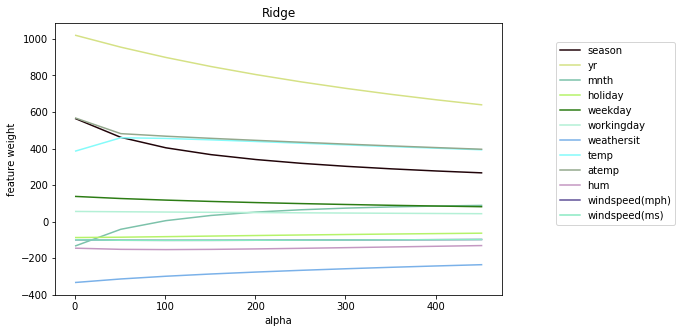

In [40]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Ответы на следующие вопросы можно давать, глядя на графики или выводя коэффициенты на печать.

__Блок 2. Ответьте на вопросы (каждый 0.25 балла)__:
1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
    * Ответ: Lasso
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
    * Ответ: Веса Lasso становятся равны нулю. В целом, L1-регуляризация способствует разреженности функции, когда лишь немногие факторы не равны нулю. При L1-регуляризации дополнительный член является модулем. Градиентный спуск движется в направлении производной. Производная при модуле где Х больше нуля является константой с абсолютной величиной, равной единице и равна минус 1 при Х меньше нуля. При Х равном нулю производная равна нулю. Поэтому при L1-регуляризации градиентный спуск будет стремиться к нулю с постоянной скоростью, а достигнув его, там и останется.   
1. Можно ли утверждать, что Lasso исключает один из признаков windspeed при любом значении alpha > 0? А Ridge? Ситается, что регуляризатор исключает признак, если коэффициент при нем < 1e-3.
    * Ответ: При alpha=1e-3 Lasso исключает а Ridge не исключает а уравнивает. 
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
    * Ответ: Lasso

Далее будем работать с Lasso.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

In [51]:
from sklearn.linear_model import LassoCV

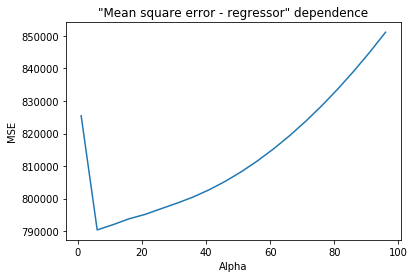

Alpha =  6

Feature-coefficient pair


[('season', 532.02),
 ('yr', 1015.06),
 ('mnth', -100.04),
 ('holiday', -83.29),
 ('weekday', 132.5),
 ('workingday', 51.56),
 ('weathersit', -330.56),
 ('temp', 370.68),
 ('atemp', 581.4),
 ('hum', -140.01),
 ('windspeed(mph)', -191.77),
 ('windspeed(ms)', -0.0)]

In [63]:
# Обучите регрессор LassoCV на всех параметрах регуляризации из alpha
alphas = np.arange(1, 100, 5)
# Lasso linear model with iterative fitting along a regularization path
# cv determines the cross-validation splitting strategy. Possible inputs for cv are:
# None, to use the default 3-fold cross-validation,
# integer, to specify the number of folds.
# CV splitter,
# An iterable yielding (train, test) splits as arrays of indices.
fitted_Lasso_Cross_Validation = LassoCV(cv=3, random_state=0, alphas=alphas).fit(X, y)
# Постройте график _усредненного_ по строкам MSE в зависимости от alpha. 
plt.plot(fitted_Lasso_Cross_Validation.alphas_, np.mean(Lasso_Cross_Validation.mse_path_, axis=1))
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('\"Mean square error - regressor\" dependence')
plt.show()
# Выведите выбранное alpha, 
print 'Alpha = ', fitted_Lasso_Cross_Validation.alpha_
# а также пары "признак-коэффициент" для обученного вектора коэффициентов
the_LCV_features_coefficients = zip(df.columns, fitted_Lasso_Cross_Validation.coef_.round(2))
print '\nFeature-coefficient pair' 
the_LCV_features_coefficients



Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

Split  0 : Alpha  41 , MSE  843336.18


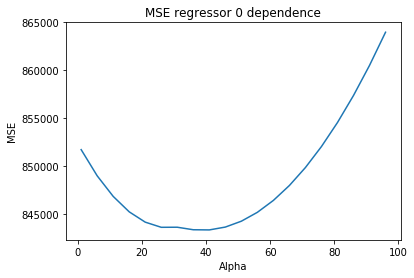

Split  1 : Alpha  6 , MSE  772598.5


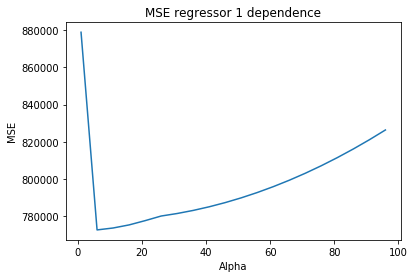

Split  2 : Alpha  1 , MSE  745668.61


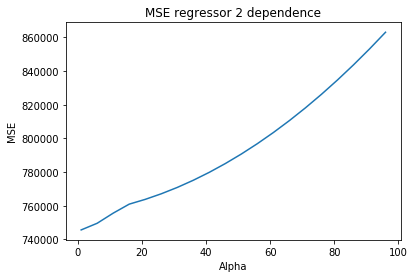

In [157]:
alphas = np.arange(1, 100, 5)
# Выведите значения alpha, соответствующие минимумам MSE на каждом разбиении (то есть по столбцам).
a_part_of_fitted_LCV = LassoCV(cv=3, random_state=0, alphas=alphas).fit(X, y)
for index, value in enumerate(np.min(a_part_of_fitted_LCV.mse_path_, axis=0)):
    minimal_index = a_part_of_fitted_LCV.mse_path_.argmin(axis=0)[index]
    alpha = a_part_of_fitted_LCV.alphas_[minimal_index]
    print 'Split ', index, ':', 'Alpha ', alpha, ', MSE ', value.round(2)
    # На трех отдельных графиках визуализируйте столбцы .mse_path_
    plt.plot(a_part_of_fitted_LCV.alphas_, a_part_of_fitted_LCV.mse_path_[:, index])  
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.title('MSE regressor ' + str(index) + ' dependence')
    plt.show()


На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

Наконец, как принято в анализе данных, давайте проинтерпретируем результат.

__Блок 3. Ответьте на вопросы (каждый 0.5 балла):__
1. В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей cnt от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость cnt от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
    * Ответ: ('season', 532.02), ('yr', 1015.06), ('atemp', 581.4), ('temp', 370.68). Наблюдается ярко выраженная линейная зависимость у признаков 'atemp' и 'temp'. Это логично. Однако логично и то, что при достижении некоего порогового значения зависимость перестанет быть линейной, поскольку при слишком высокой температуре люди будут меньше кататься. Признак 'yr' отражает тренд на рост спроса но сам не влияет на показатель 'cnt'. Связь признака 'season' с 'cnt' имеет синусоидальный характер, что логично, поскольку именно так 'season' связан с 'temp'.
2. Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
    * Ответ: ('weathersit', -330.56), ('windspeed(mph)', -191.77), ('hum', -140.01). Видна убывающая линейная зависимость у всех трех признаков. Это логично. 
3. Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?
    * Ответ: ('windspeed(ms)', -0.0). Модель исключила этот признак покольку он избыточный, польностью дублирует 'windspeed(mph)'. Сам фактор, описываемый признаком, линейно влияет, вызывает снижение 'cnt'.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель, а это времязатратный процесс, особенно если нужно обучаться на больших объемах данных.